In [64]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from PLOTTING import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [65]:
pas="1"
config="2"


In [66]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")

print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: 0
W2max: 1.5
dxmin: -0.481
dxmax: 0.498
dymin: -0.822
dymax: 0.8
dybgmin: -1.4
dybgmax: 1.4
Coin Min: 95 Coin Max: 106


In [67]:

def dxdyFunc(config):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages

    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfilep = (f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root")
    if config == "4":
        config = "4b"
    
    C = TChain("Tout")
    B = TChain("Tout")
    
    C.Add(rootfilenp)
    B.Add(rootfilep)

    dx_p, dy_p, W2_p, coin_p,fnucl  = array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np= array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    
    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2=["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)

    B.SetBranchStatus("weight", 1)
    B.SetBranchStatus("fnucl",1)
    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    B.SetBranchAddress("dx", dx_p)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    C.SetBranchAddress("helicity", helicity_np)
    #B.SetBranchAddress("helicity", helicity_p)
    C.SetBranchAddress("IHWP", IHWP_np)
    #B.SetBranchAddress("IHWP", IHWP_p)
    C.SetBranchAddress("coin_time", coin_np)
    #B.SetBranchAddress("coin_time", coin_pp)
    C.SetBranchAddress("runnum", runnum_np)
    #B.SetBranchAddress("runnum", runnum_p)
    B.SetBranchAddress("weight", weight)
    B.SetBranchAddress("fnucl", fnucl)
    

    nbins=30
    gen4=.5
    gen3=1
    gen2=1

    hdxdy=r.TH2F("hdxdy", "dX vs dY", nbins, -1, 1, nbins, -gen3, gen3)
    hdxdyFull=r.TH2F("hdxdy", "dX vs dY", 100, -4, 4, 100, -4, 4)
    nbins=80
    hw2=r.TH2F("hw2", "W2 vs dX", nbins, -1,3, nbins, -3, 1)
    hw2Full=r.TH2F("hw2Full", "W2 vs dX", nbins, -1,3, nbins, -3, 1)
    
    # JSONManager part is omitted for now

    nEntries_np = C.GetEntries()
    #rxn3 = (dxmax - dxmin) / 2.0
    #ryn3 = (dymax - dymin) / 2.0
    #x0_n3 = (dxmax + dxmin) / 2.0
    #y0_3 = (dymax + dymin) / 2.0
    #ncut = (dx_np[0] - x0_n3)**2 / rxn3**2 + (dy_np[0] - y0_3)**2 / ryn3**2 <= 1
    

    
    # Data loop
    for i in range(nEntries_np):
        C.GetEntry(i)
        #____________CUTS_______________________________      
        ycut = dymin < dy_np[0] < dymax
        bgycut=dybgmin<dy_np[0]<dybgmax
        coin_cut = coinmin < coin_np[0] < coinmax
        W2cut=W2min < W2_np[0] < W2max
        xcutn = dxmin < dx_np[0] < dxmax
        #________________________________________________ 

        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue
        hw2Full.Fill(W2_np[0],dx_np[0])
        
        
        if coin_cut and W2cut and runnum_np[0] > 2165:
            hdxdy.Fill(dy_np[0], dx_np[0])
        hdxdyFull.Fill(dy_np[0], dx_np[0])
            
            
        if coin_cut and ycut and runnum_np[0] > 2165:
            hw2.Fill(W2_np[0],dx_np[0])

    return hdxdy,hdxdyFull,hw2,hw2Full



In [68]:
hdxdy,hdxdyFull,hw2,hw2Full=dxdyFunc(config)

Error in <THashList::Delete>: A list is accessing an object (0x36553950) already deleted (list name = THashList)


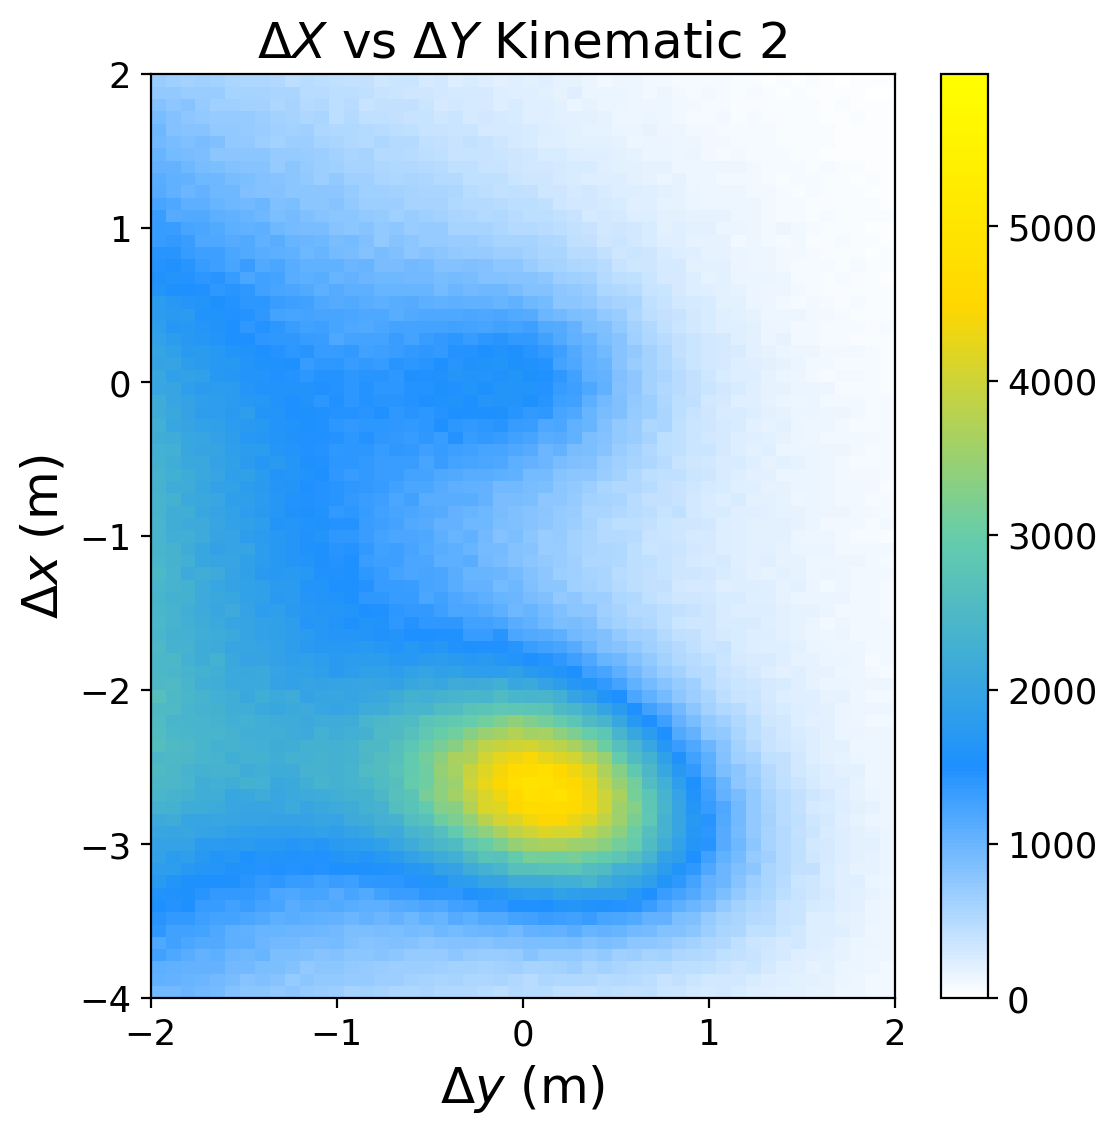

In [69]:
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ROOT as r
import array
import os

colors = ['white', 'dodgerblue', 'mediumaquamarine', 'gold', 'yellow']
fig, ax = plt.subplots(figsize=(6, 6),dpi=200)

# Create a custom color map
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
x_edges, y_edges, data = Function_EXTRACTHIST(hdxdyFull)

# Set limits for axes
ax.set_xlim(-2, 2)
ax.set_ylim(-4, 2)

# Set font size
fs = 15  # Define font size variable before using it

# Set titles and labels with the updated font size
plt.title(f"$\Delta X$ vs $\Delta Y$ Kinematic {config}", fontsize=fs*1.20)
plt.xlabel(r'$\Delta y$ (m)', fontsize=fs*1.20)
plt.ylabel(r'$\Delta x$ (m)', fontsize=fs*1.20)

# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=fs*.85)

# Plot the data using pcolormesh
#plt.pcolormesh(x_edges, y_edges, data.T, shading='auto', cmap=cmap)

pcm = plt.pcolormesh(x_edges, y_edges, data.T, shading='auto', cmap=cmap)
cbar = plt.colorbar(pcm, ax=ax)
cbar.ax.tick_params(labelsize=fs*.85)  # Adjust font size for color bar ticks
# Add a color bar
#plt.colorbar()

# Show the plot
plt.show()


In [70]:
count_ranges=0

In [71]:
def Function_PLOT2DROOTHIST(hist, title, filename,count_ranges,Full):
    from matplotlib.colors import LogNorm
    from matplotlib.colors import PowerNorm

    from IPython.display import Image, display
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import ROOT as r
    import array
    import os
    colors = ['white', 'dodgerblue','mediumaquamarine','gold','yellow']
    fig, ax = plt.subplots(figsize=(8, 6))
    #plt.figure(figsize=(8, 6))

    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    x_edges, y_edges, data = Function_EXTRACTHIST(hist)
    
   
    plt.pcolormesh(x_edges, y_edges, data.T, shading='auto', cmap=cmap)
    plt.colorbar()
    fs=15
    #for count_range_min, count_range_max in count_ranges:
    #    plt.axvspan(count_range_min, count_range_max, color='red', alpha=0.25)
    #    plt.axvline(count_range_min, color='black', linestyle='-', linewidth=1)
    #    plt.axvline(count_range_max, color='black', linestyle='-', linewidth=1)
    #plt.axhline(dxmin, color='black', linestyle='-', linewidth=1)
    #plt.axhline(dxmax, color='black', linestyle='-', linewidth=1)
    #plt.axhspan(dxmin, dxmax, color='yellow', alpha=0.25)

    dylim=4

    #rect=patches.Rectangle((dymin,dxmin), abs(dymax-dymin), dxmax-dxmin, linewidth=5, edgecolor='red', facecolor='pink', alpha=0.3)
    
    #rect2=patches.Rectangle((dybgmax,dxmin), abs(dybgmin-dylim), dxmax-dxmin, linewidth=3, edgecolor='black', facecolor='magenta', alpha=0.3)
    #plt.gca().add_patch(rect2)
    #rect.set_facecolor((1, 0.75, 0.8, 0.3))  # RGBA for pink with alpha=0.3
    #rect.set_edgecolor((, 0, 0, 1.0))
    #plt.gca().add_patch(rect)
    
    #face_rect = patches.Rectangle((dymin, dxmin), abs(dymax-dymin), abs(dxmax-dxmin), facecolor='pink', edgecolor='none', alpha=0.3)
   # plt.gca().add_patch(face_rect)

# Create an ellipse for the edge color
    center_y = (dxmax + dxmin) / 2
    center_x = (dymax + dymin) / 2
    height = dxmax - dxmin
    width = dymax - dymin

    # Create an ellipse
    ellipse = plt.matplotlib.patches.Ellipse((center_x, center_y), width, height, edgecolor='red',linewidth=3, facecolor='none')

    # Create a plot
    #fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.add_patch(ellipse)

    # Set the limits of the plot to the rectangle bounds
    ax.set_xlim(dxmin - 1, dxmax + 1)
    ax.set_ylim(dymin - 1, dymax + 1)

    # Add grid and show the plot
    #plt.grid(True)


    edge_rect = patches.Rectangle((dymin, dxmin), abs(dymax-dymin), abs(dxmax-dxmin), linewidth=3, facecolor='none', edgecolor='black')
    plt.gca().add_patch(edge_rect)
    plt.title(title,fontsize=fs)
    plt.xlabel(r'$\Delta y$',fontsize=fs)
    plt.ylabel(r'$\Delta x$',fontsize=fs)
    if not Full:
        plt.ylim((-1,1))
        plt.xlim((-1,1))
    else:
        plt.ylim((-3,1))
        plt.xlim((-3,3))

    plt.savefig(f'../plots/{filename}')
    plt.show()
    plt.close()

In [72]:
#dymin=-.45
#dymax=.6
#dxmax=.4
#dxmin=-.45

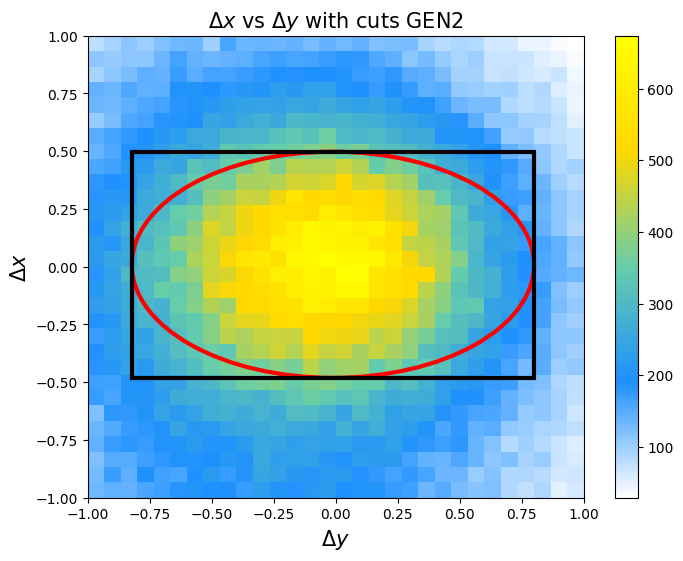

In [73]:

Function_PLOT2DROOTHIST(hdxdy,f"$\Delta x$ vs $\Delta y$ with cuts GEN{config}","BGdxvsdy",count_ranges,False)



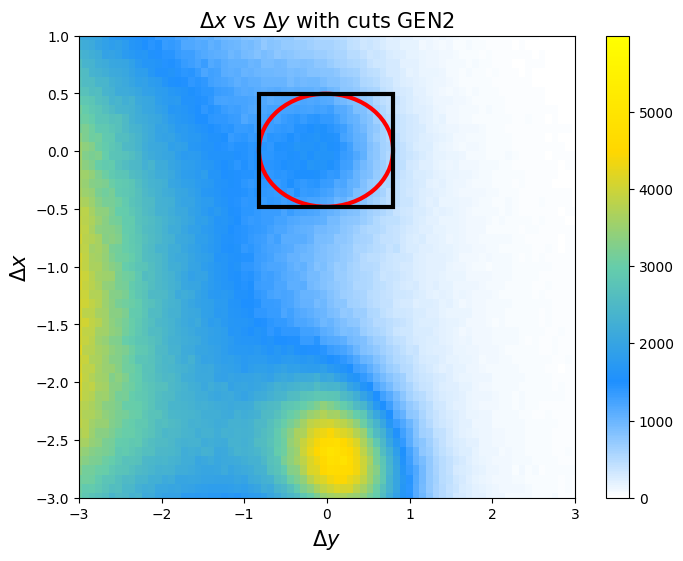

In [74]:
Function_PLOT2DROOTHIST(hdxdyFull,f"$\Delta x$ vs $\Delta y$ with cuts GEN{config}","BGdxvsdy",count_ranges,True)

# W2

In [81]:
def Function_PLOT2DROOTHIST(hist, title, filename,count_ranges,Full):
    from matplotlib.colors import LogNorm
    from matplotlib.colors import PowerNorm

    from IPython.display import Image, display
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import ROOT as r
    import array
    import os
    colors = ['white', 'dodgerblue','mediumaquamarine','gold','yellow']
    fig, ax = plt.subplots(figsize=(8, 6),dpi=200)
    #plt.figure(figsize=(8, 6))

    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    x_edges, y_edges, data = Function_EXTRACTHIST(hist)
    
   
    plt.pcolormesh(x_edges, y_edges, data.T, shading='auto', cmap=cmap)
    plt.colorbar()
    fs=15
    #for count_range_min, count_range_max in count_ranges:
    #    plt.axvspan(count_range_min, count_range_max, color='red', alpha=0.25)
    #    plt.axvline(count_range_min, color='black', linestyle='-', linewidth=1)
    #    plt.axvline(count_range_max, color='black', linestyle='-', linewidth=1)
    #plt.axhline(dxmin, color='black', linestyle='-', linewidth=1)
    #plt.axhline(dxmax, color='black', linestyle='-', linewidth=1)
    #plt.axhspan(dxmin, dxmax, color='yellow', alpha=0.25)

    dylim=4

    #rect=patches.Rectangle((dymin,dxmin), abs(dymax-dymin), dxmax-dxmin, linewidth=5, edgecolor='red', facecolor='pink', alpha=0.3)
    
    #rect2=patches.Rectangle((dybgmax,dxmin), abs(dybgmin-dylim), dxmax-dxmin, linewidth=3, edgecolor='black', facecolor='magenta', alpha=0.3)
    #plt.gca().add_patch(rect2)
    #rect.set_facecolor((1, 0.75, 0.8, 0.3))  # RGBA for pink with alpha=0.3
    #rect.set_edgecolor((, 0, 0, 1.0))
    #plt.gca().add_patch(rect)
    
    #face_rect = patches.Rectangle((dymin, dxmin), abs(dymax-dymin), abs(dxmax-dxmin), facecolor='pink', edgecolor='none', alpha=0.3)
   # plt.gca().add_patch(face_rect)

# Create a rectangle for the edge color

    #edge_rect = patches.Rectangle((W2min, dxmin), abs(W2max-W2min), abs(dxmax-dxmin), linewidth=3, facecolor='none', edgecolor='black')
   # plt.gca().add_patch(edge_rect)
    
    #plt.axhline(y=dxmin, color='black', linewidth=2)
    #plt.axhline(y=dxmax, color='black', linewidth=2)

    plt.title(title,fontsize=fs)
    plt.xlabel(r'W2 (GeV)',fontsize=fs)
    plt.ylabel(r'$\Delta x$ (m)',fontsize=fs)
    if not Full:
        plt.ylim((-1,1))
        plt.xlim((-1,1))
    else:
        plt.ylim((-3,1))
        plt.xlim((-1,3))

    #plt.savefig(f'../plots/{filename}')
    plt.show()
    plt.close()

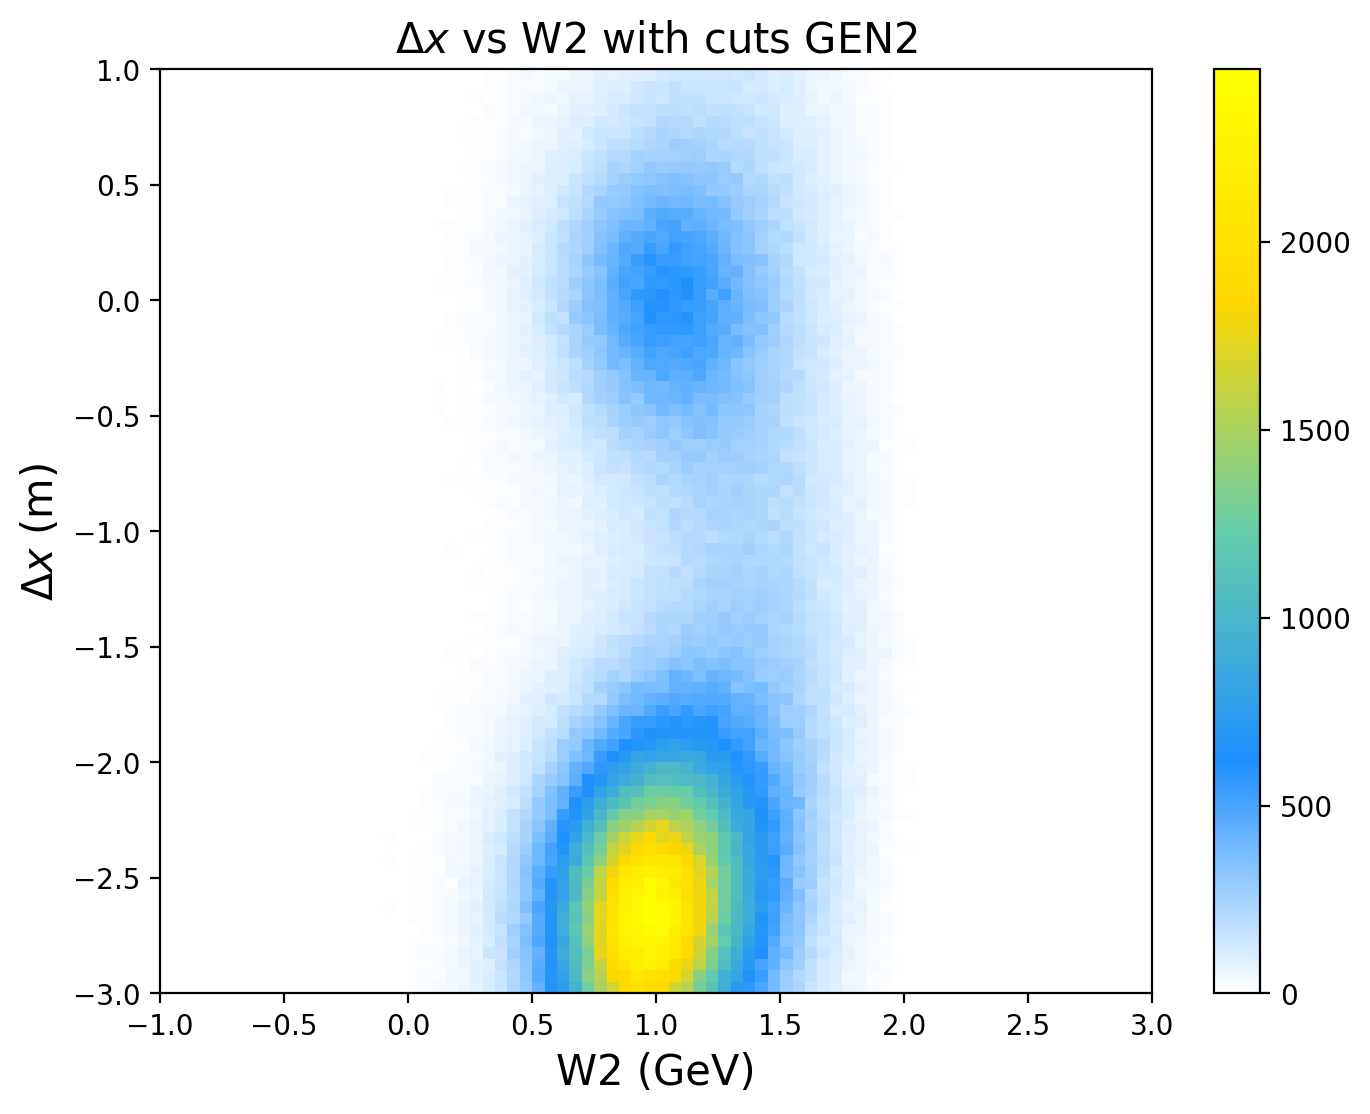

In [82]:
Function_PLOT2DROOTHIST(hw2,f"$\Delta x$ vs W2 with cuts GEN{config}","W2vsdX",count_ranges,True)

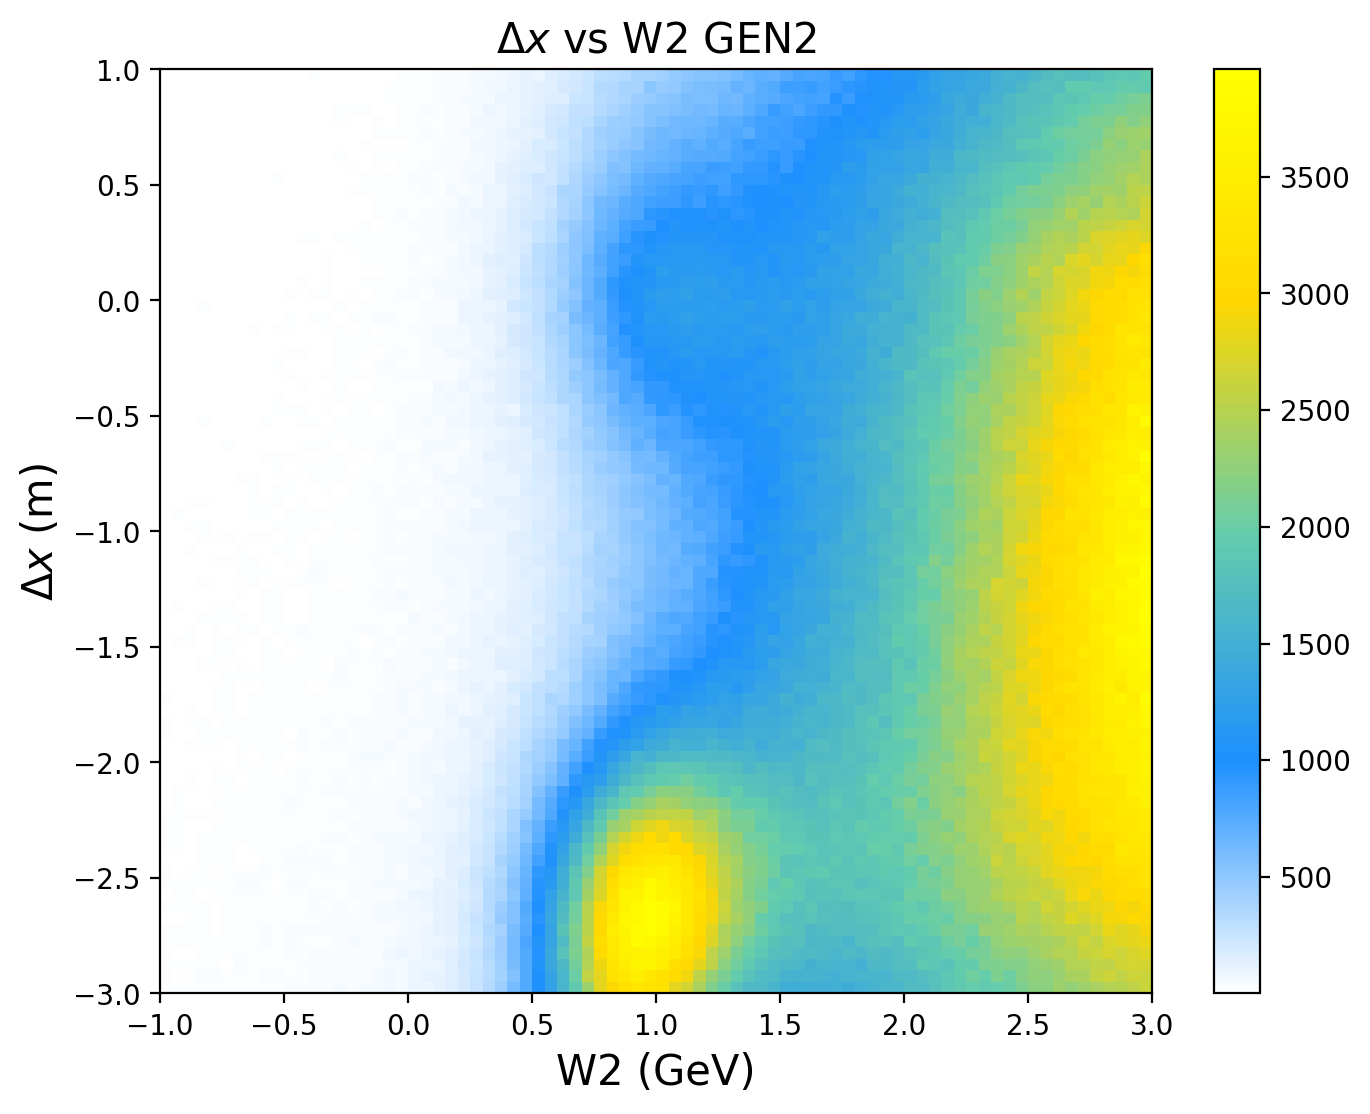

In [83]:
Function_PLOT2DROOTHIST(hw2Full,f"$\Delta x$ vs W2 GEN{config}","W2vsdX",count_ranges,True)